## 밸류 팩터: 주가배수 지표 활용(per, pbr, pcr, psr) -> 평균 하위 10개 종목 추천

In [1]:
import pandas as pd
from datetime import date, datetime, timedelta
import pandas as pd
import time
import numpy as np
# from sklearn.preprocessing import MinMaxScaler, Normalizer

import FinanceDataReader as fdr
# from pykrx import stock

# import dart_fss as dart
import requests
import bs4
# from urllib.request import urlopen
# import webbrowser
# from selenium import webdriver
import json
# from urllib.request import urlopen
# import xmltodict
# import xml.etree.ElementTree as ET

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# %matplotlib inline

In [2]:
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="./malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
nowDate = datetime.today()

startDate = (nowDate - timedelta(90)).strftime("%Y%m%d")
endDate = (nowDate - timedelta(1)).strftime("%Y%m%d")

today = nowDate.strftime("%Y%m%d")
# testStartDate = (nowDate - timedelta(180)).strftime("%Y%m%d")
# testEndDate = (nowDate - timedelta(91)).strftime("%Y%m%d")

In [4]:
print(startDate, endDate)

20200402 20200630


### 1. 데이터 불러오기

In [5]:
resultDf = pd.read_csv("./finalResultDf.csv", encoding="ms949", dtype = {"Ticker":str, "CorpCode":str}, index_col=False)

In [6]:
resultDf.head(1)

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,...,OCF,NumOfIssuedShares,Close,MarketValue,ROE,ROA,PER,PBR,PCR,PSR
0,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도,...,8100020626,14480227,23300,337389289100,0.065685,0.017479,42.599051,2.798114,41.652893,2.807348


### 2. 이상치 제거 : lower bound, upper bound

In [7]:
def calcBound(series):
    q3 = series.quantile(0.25)
    q1 = series.quantile(0.75)
    upper = q3 + (q1 - q3) * 1.5
    lower = q1 - (q1 - q3) * 1.5
    return({"upperBound" : upper, "lowerBound" : lower})

In [8]:
PERBounds = calcBound(resultDf.PER)
PBRBounds = calcBound(resultDf.PBR)
PCRBounds = calcBound(resultDf.PCR)
PSRBounds = calcBound(resultDf.PSR)

In [9]:
refinedDf = resultDf[(resultDf.PER < PERBounds["upperBound"]) & (resultDf.PER > PERBounds["lowerBound"])
                 & (resultDf.PBR < PBRBounds["upperBound"]) & (resultDf.PBR > PBRBounds["lowerBound"])
                 & (resultDf.PCR < PCRBounds["upperBound"]) & (resultDf.PCR > PCRBounds["lowerBound"])
                 & (resultDf.PSR < PSRBounds["upperBound"]) & (resultDf.PSR > PSRBounds["lowerBound"])]

In [10]:
refinedDf.head(1)

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,...,OCF,NumOfIssuedShares,Close,MarketValue,ROE,ROA,PER,PBR,PCR,PSR
0,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도,...,8100020626,14480227,23300,337389289100,0.065685,0.017479,42.599051,2.798114,41.652893,2.807348


### 3. PER, PBR, PCR, PSR 모두 하위 25% 이내의 종목만 필터링

In [11]:
refinedDf = refinedDf[(refinedDf.PER < refinedDf.PER.quantile(0.25))
               & (refinedDf.PBR < refinedDf.PBR.quantile(0.25))
               & (refinedDf.PCR < refinedDf.PCR.quantile(0.25))
               & (refinedDf.PSR < refinedDf.PSR.quantile(0.25))]

In [12]:
refinedDf = refinedDf.reset_index(drop=True)

In [13]:
refinedDf.head()

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,...,OCF,NumOfIssuedShares,Close,MarketValue,ROE,ROA,PER,PBR,PCR,PSR
0,006360,KOSPI,GS건설,건물 건설업,"토목공사,건축공사,주택공사,산업플랜트공사,리모델링공사,시설물유지관리공사/산업설비설계...",1981-08-03,12월,"허창수, 임병용(각자 대표이사)",http://www.gsconst.co.kr/,서울특별시,...,182442668721,80097804,24550,1966401088200,0.032195,0.011275,14.452568,0.465303,10.778186,0.916488
1,294870,KOSPI,HDC현대산업개발,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"권순호, 정경구",http://www.hdc-dvp.com,서울특별시,...,234760711167,65907330,21100,1390644663000,0.041467,0.020519,12.683137,0.525935,5.923669,1.385399
2,021320,KOSDAQ,KCC건설,건물 건설업,"토목 건축공사, 분양공사",2001-08-21,12월,"정몽열,윤희영",http://www.kccworld.net,서울특별시,...,108743481749,21400000,6260,133964000000,0.040605,0.015719,8.462403,0.343614,1.231927,0.404039
3,030200,KOSPI,KT,전기 통신업,"유무선통신사업,공중전기통신사업,인터넷,전자상거래,네트워크(전용회선,데이터통신,초고속...",1998-12-23,12월,구현모,http://www.kt.com,경기도,...,906192000000,261111808,23550,6149183078400,0.024740,0.011823,19.214696,0.475363,6.785740,1.388370
4,058860,KOSPI,KTis,기타 정보 서비스업,"114전화번호안내, 고객센터",2010-12-17,12월,이응호,http://www.ktis.co.kr,서울특별시,...,12812209274,34802000,1945,67689890000,0.030251,0.016158,13.194205,0.399133,5.283233,0.608633


### 4. PER, PBR, PCR, PSR 정규화 (0 ~ 1)

In [14]:
def minMaxNorm(inputData):
    maxValue = max(inputData)
    minValue = min(inputData)
    deNormValue = maxValue - minValue
    plusData = inputData - minValue
    outData = inputData
    if deNormValue != 0 :
        outData = plusData / deNormValue
    else:
        pass
    return outData

In [15]:
refinedDf["PER_Norm"] = minMaxNorm(refinedDf.PER)
refinedDf["PBR_Norm"] = minMaxNorm(refinedDf.PBR)
refinedDf["PCR_Norm"] = minMaxNorm(refinedDf.PCR)
refinedDf["PSR_Norm"] = minMaxNorm(refinedDf.PSR)

### 5. PER, PBR, PCR, PSR의 평균 하위 10개 종목 추천

In [16]:
recommendationCount = 10

In [17]:
rcmdDf = refinedDf.copy()

In [18]:
rcmdDf["Norm_Mean"] = (rcmdDf.PER_Norm + rcmdDf.PBR_Norm + rcmdDf.PCR_Norm + rcmdDf.PSR_Norm) / 4

In [19]:
rcmdDf = rcmdDf.sort_values("Norm_Mean", ascending=True, ignore_index=True)[:recommendationCount]

In [20]:
firstRcmdDf = rcmdDf[0:5]

In [21]:
secondRcmdDf = rcmdDf[5:10].reset_index(drop = True)

### 6. 추천 종목의 최근 3달 가격 추이 시각화

In [22]:
def perfomanceEvaluation(rcmdDf, start, end, fileName):

    resultList = []
    for i in range(0, len(rcmdDf)):
        tmpDf = fdr.DataReader(symbol = rcmdDf.Ticker[i], start = start, end = end)
        performance = tmpDf.Close / tmpDf.Close[0]
        performanceDf = performance.to_frame(name = "Performance")
        performanceDf = pd.concat([tmpDf, performanceDf], axis = 1)
        resultList.append(performanceDf)
    
    meanPerformanceList = []
    for i in range(0, len(resultList[0].Performance)):
        sumPerformance = 0
        for j in range(0, len(resultList)):
            sumPerformance = sumPerformance + resultList[j].Performance[i]
        meanPerformance = (sumPerformance / len(resultList))
        meanPerformanceList.append(meanPerformance)
    meanPerformanceDf = pd.DataFrame(meanPerformanceList)
    
    meanPerformanceDf = pd.DataFrame(meanPerformanceList, columns=["MeanPerformance"])
    meanPerformanceDf.index = [resultList[0].index]
    
    x = resultList[0].index.strftime("%Y-%m-%d")
    y = resultList[0].Performance
    y2 = resultList[1].Performance
    y3 = resultList[2].Performance
    y4 = resultList[3].Performance
    y5 = resultList[4].Performance
    y6 = meanPerformanceDf
    
    plt.figure(figsize = (12,7))
    plt.plot(x,y,"b-",label=rcmdDf.Name[0]+rcmdDf.Ticker[0])
    plt.plot(x,y2, "g-",label=rcmdDf.Name[1]+rcmdDf.Ticker[1])
    plt.plot(x,y3, "r-",label=rcmdDf.Name[2]+rcmdDf.Ticker[2])
    plt.plot(x,y4, "y-",label=rcmdDf.Name[3]+rcmdDf.Ticker[3])
    plt.plot(x,y5, "c-",label=rcmdDf.Name[4]+rcmdDf.Ticker[4])
    plt.plot(x,y6, "k-",label="평균", linewidth=4)
    plt.xlabel("Date")
    plt.ylabel("Performance")
    plt.title("Recommend")
    plt.axhline(y=1.0, color='k')
    plt.xticks(x, x[::10], rotation=45) # set divisor
    plt.locator_params(axis='x', nbins=len(x)/10)  # set divisor 
    plt.legend(loc="best")
    
    plt.savefig(fileName)

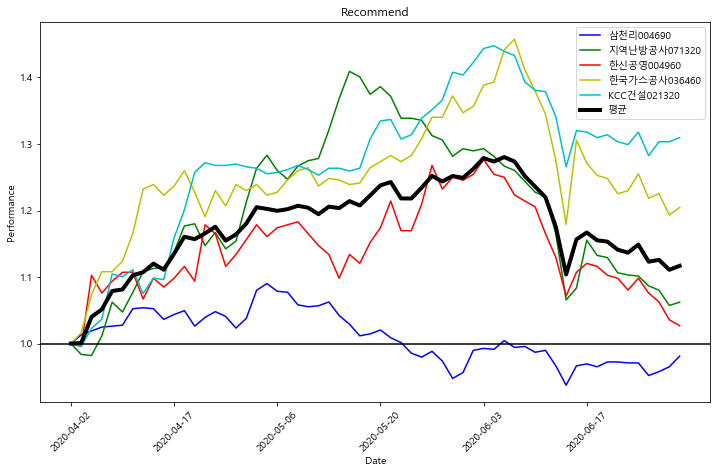

In [23]:
# 1~5위
perfomanceEvaluation(firstRcmdDf, startDate, endDate, (today + "Factor_Value_1"))

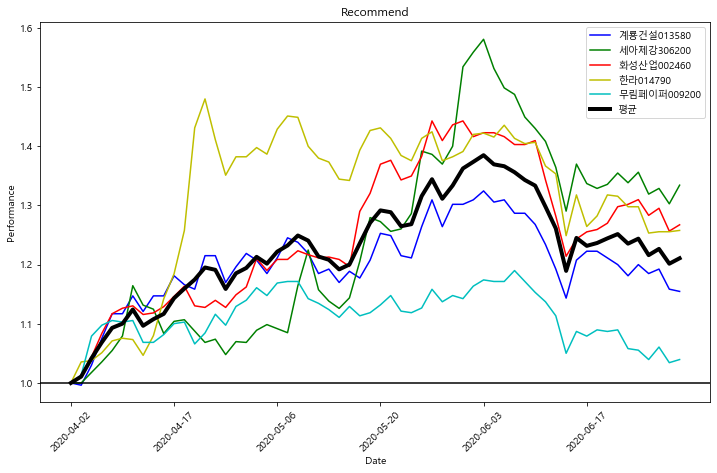

In [24]:
# 6~10위
perfomanceEvaluation(secondRcmdDf, startDate, endDate, (today + "Factor_Value_2"))

### 7. 테스트용 종목의 최근 3달 가격 추이 시각화 (전략의 유효성 검증)

In [25]:
testResultDf = pd.read_csv("./testFinalResultDf.csv", encoding="ms949", dtype = {"Ticker":str, "CorpCode":str}, index_col=False)

In [26]:
testPERBounds = calcBound(testResultDf.PER)
testPBRBounds = calcBound(testResultDf.PBR)
testPCRBounds = calcBound(testResultDf.PCR)
testPSRBounds = calcBound(testResultDf.PSR)

In [27]:
testRefinedDf = testResultDf[(resultDf.PER < testPERBounds["upperBound"]) & (testResultDf.PER > testPERBounds["lowerBound"])
                 & (testResultDf.PBR < testPBRBounds["upperBound"]) & (testResultDf.PBR > testPBRBounds["lowerBound"])
                 & (testResultDf.PCR < testPCRBounds["upperBound"]) & (testResultDf.PCR > testPCRBounds["lowerBound"])
                 & (testResultDf.PSR < testPSRBounds["upperBound"]) & (testResultDf.PSR > testPSRBounds["lowerBound"])]

In [28]:
testRefinedDf = testRefinedDf[(testRefinedDf.PER < testRefinedDf.PER.quantile(0.25))
               & (testRefinedDf.PBR < testRefinedDf.PBR.quantile(0.25))
               & (testRefinedDf.PCR < testRefinedDf.PCR.quantile(0.25))
               & (testRefinedDf.PSR < testRefinedDf.PSR.quantile(0.25))]

In [29]:
testRefinedDf["PER_Norm"] = minMaxNorm(testRefinedDf.PER)
testRefinedDf["PBR_Norm"] = minMaxNorm(testRefinedDf.PBR)
testRefinedDf["PCR_Norm"] = minMaxNorm(testRefinedDf.PCR)
testRefinedDf["PSR_Norm"] = minMaxNorm(testRefinedDf.PSR)

In [30]:
testRcmdDf = testRefinedDf.copy()

In [31]:
testRcmdDf["Norm_Mean"] = (testRcmdDf.PER_Norm + testRcmdDf.PBR_Norm + testRcmdDf.PCR_Norm + testRcmdDf.PSR_Norm) / 4

In [32]:
testRcmdDf = testRcmdDf.sort_values("Norm_Mean", ascending=True, ignore_index=True)[:recommendationCount]

In [33]:
testFirstRcmdDf = testRcmdDf[0:5]

In [34]:
testSecondRcmdDf = testRcmdDf[5:10].reset_index(drop = True)

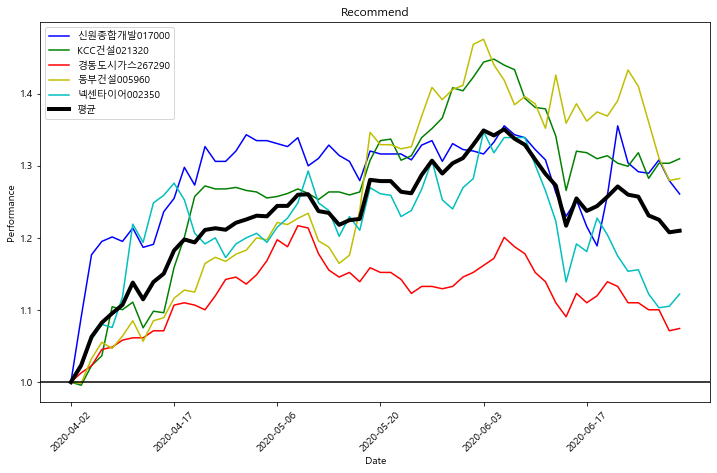

In [35]:
perfomanceEvaluation(testFirstRcmdDf, startDate, endDate, (today + "Factor_Value_Test_1"))

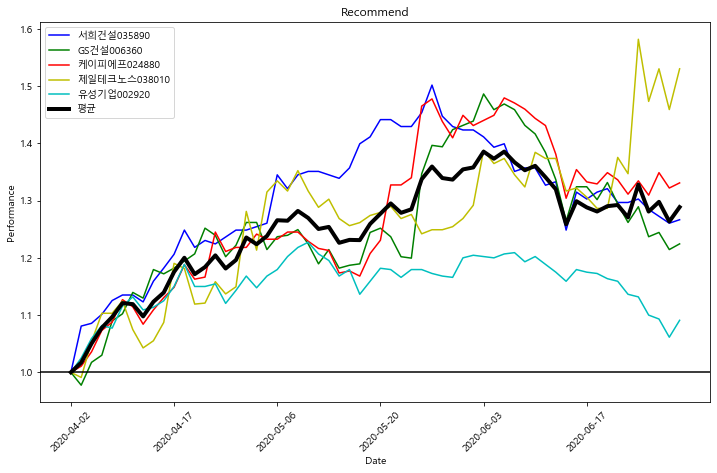

In [36]:
perfomanceEvaluation(testSecondRcmdDf, startDate, endDate, (today + "Factor_Value_Test_2"))